# SN 2022eyj for image subtraction

In [1]:
import os,sys
import importlib
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns
from scipy import signal
#---PythonPhot---#
from PythonPhot import rdpsf
#---my modules---#
import mkpsf_func
import tomoeutils
from run_hotpants import runhotpants

%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [3]:
# FITS path
fits_dir = '/home/arima/tomoe/tomoeflash/imsub/test/fits/sn2022eyj/'
fits_sci_peak = fits_dir + 'sTMQ1202203240073175631.fits'
fits_sci_rise = fits_dir + 'sTMQ1202203100072022531.fits'
fits_ref_peak = fits_dir + 'sTMQ1202203240073175631_ref_tg.fits'
fits_ref_rise = fits_dir + 'sTMQ1202203100072022531_ref_tg.fits'
# Basename
fits_sci_peak_basename = os.path.splitext(os.path.basename(fits_sci_peak))[0]
fits_sci_rise_basename = os.path.splitext(os.path.basename(fits_sci_rise))[0]

# Output directory
out_dir = '/home/arima/tomoe/tomoeflash/imsub/test/diff_fits/sn2022hrs'

In [4]:
# Open FITS file
header_sci_peak, data_sci_peak = tomoeutils.openfits(fits_sci_peak)
header_sci_rise, data_sci_rise = tomoeutils.openfits(fits_sci_rise)
header_ref_peak, data_ref_peak = tomoeutils.openfits(fits_ref_peak)

# Bkg subtraction
data_sci_peak_bkgsub =tomoeutils.subtractbkg(data_sci_peak, image_only=True)
data_sci_rise_bkgsub =tomoeutils.subtractbkg(data_sci_rise, image_only=True)
data_ref_peak_bkgsub =tomoeutils.subtractbkg(data_ref_peak, image_only=True)

mean_sci_peak = np.mean(data_sci_peak_bkgsub)
std_sci_peak = np.std(data_sci_peak_bkgsub)
mean_sci_rise = np.mean(data_sci_rise_bkgsub)
std_sci_rise = np.std(data_sci_rise_bkgsub)
mean_ref_peak = np.mean(data_ref_peak_bkgsub)
std_ref_peak = np.std(data_ref_peak_bkgsub)

In [5]:
# Position of SN2022eyj
ra, dec = 169.502292, +7.845739 # in degree (from TNS)
w_peak = WCS(header_sci_peak)
sn_pos = SkyCoord(ra, dec, frame='icrs', unit='deg')
x_peak_pix, y_peak_pix = w_peak.world_to_pixel(sn_pos) # in pixel
print(x_peak_pix, y_peak_pix)

522.5199965713067 703.7943925290174


Set OBSGEO-Y to  3491287.525 from OBSGEO-[LBH].
Set OBSGEO-Z to  3710653.939 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


### At peak phase

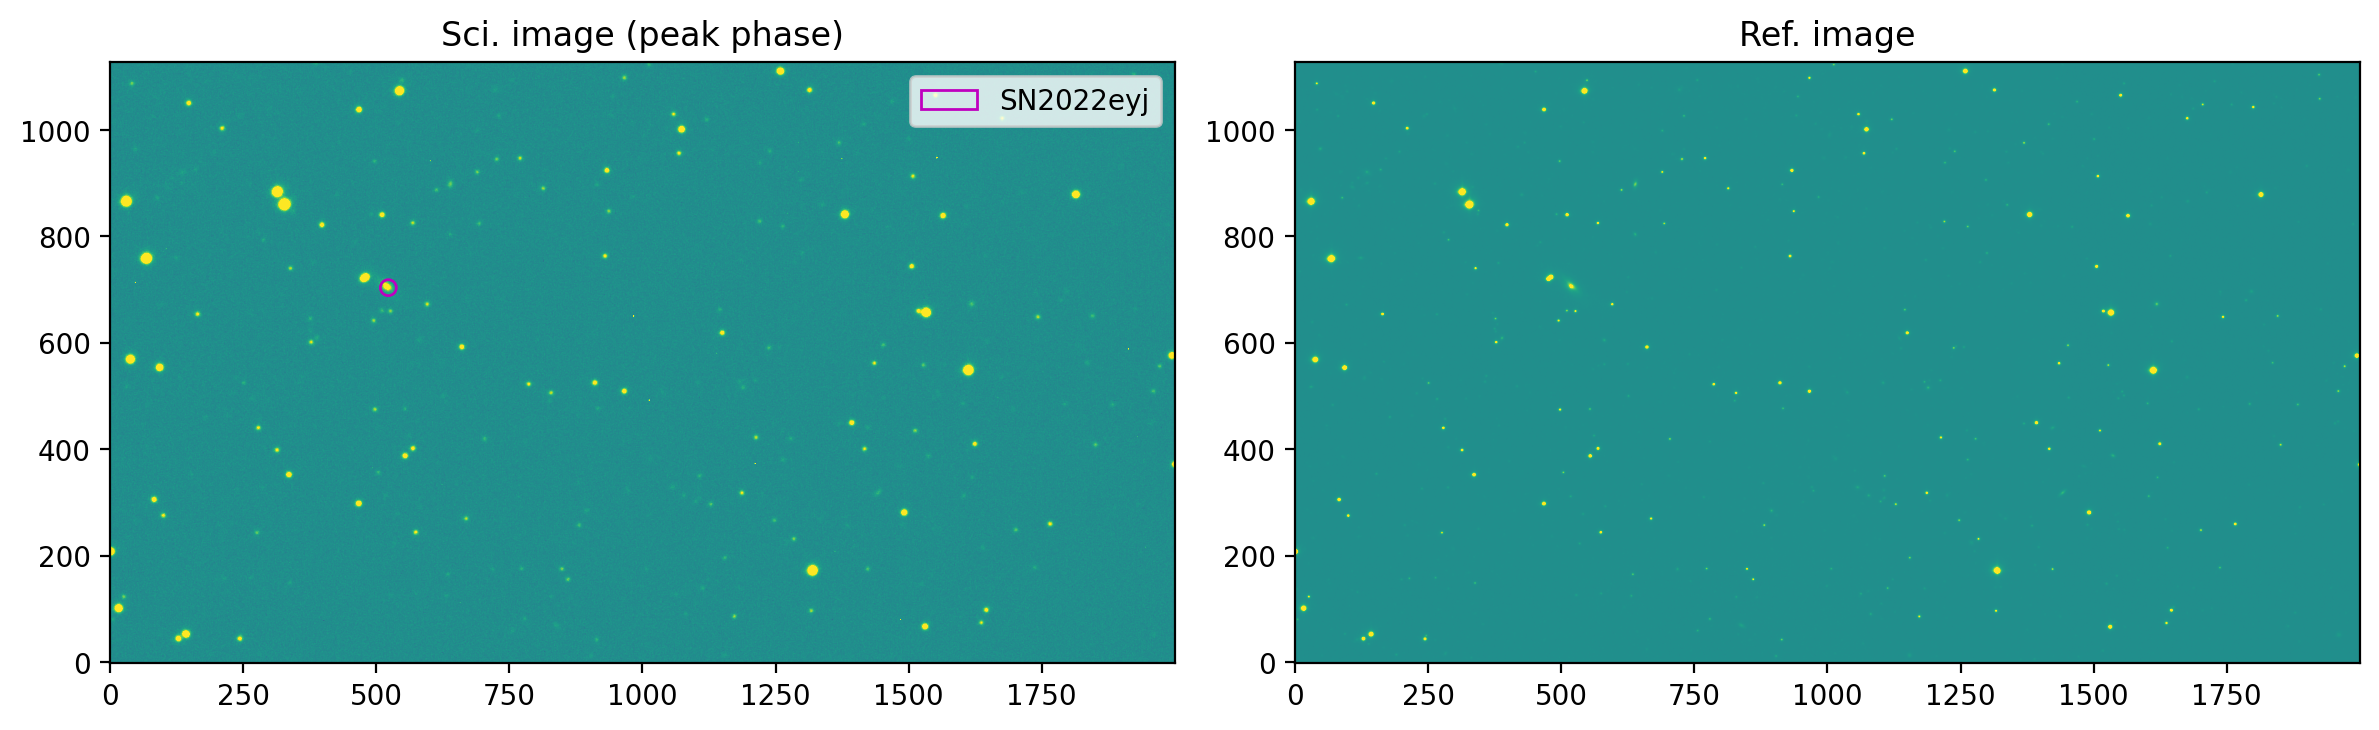

In [6]:
# Show image
sn_name = 'SN2022eyj'
sn_phase = 'peak'
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol, figsize=(12,8))
axes[0].imshow(data_sci_peak_bkgsub, vmin=mean_sci_peak-3*std_sci_peak, vmax=mean_sci_peak+3*std_sci_peak, origin='lower')
axes[0].set_title('Sci. image ({} phase)'.format(sn_phase))
c = patches.Circle(xy=(x_peak_pix, y_peak_pix), radius=15, fill=False, ec='m', lw=1, label='{}'.format(sn_name))
axes[0].add_patch(c)
axes[1].imshow(data_ref_peak, vmin=mean_ref_peak-3*std_ref_peak, vmax=mean_ref_peak+3*std_ref_peak, origin='lower')
axes[1].set_title('Ref. image')
axes[0].legend()
plt.tight_layout()

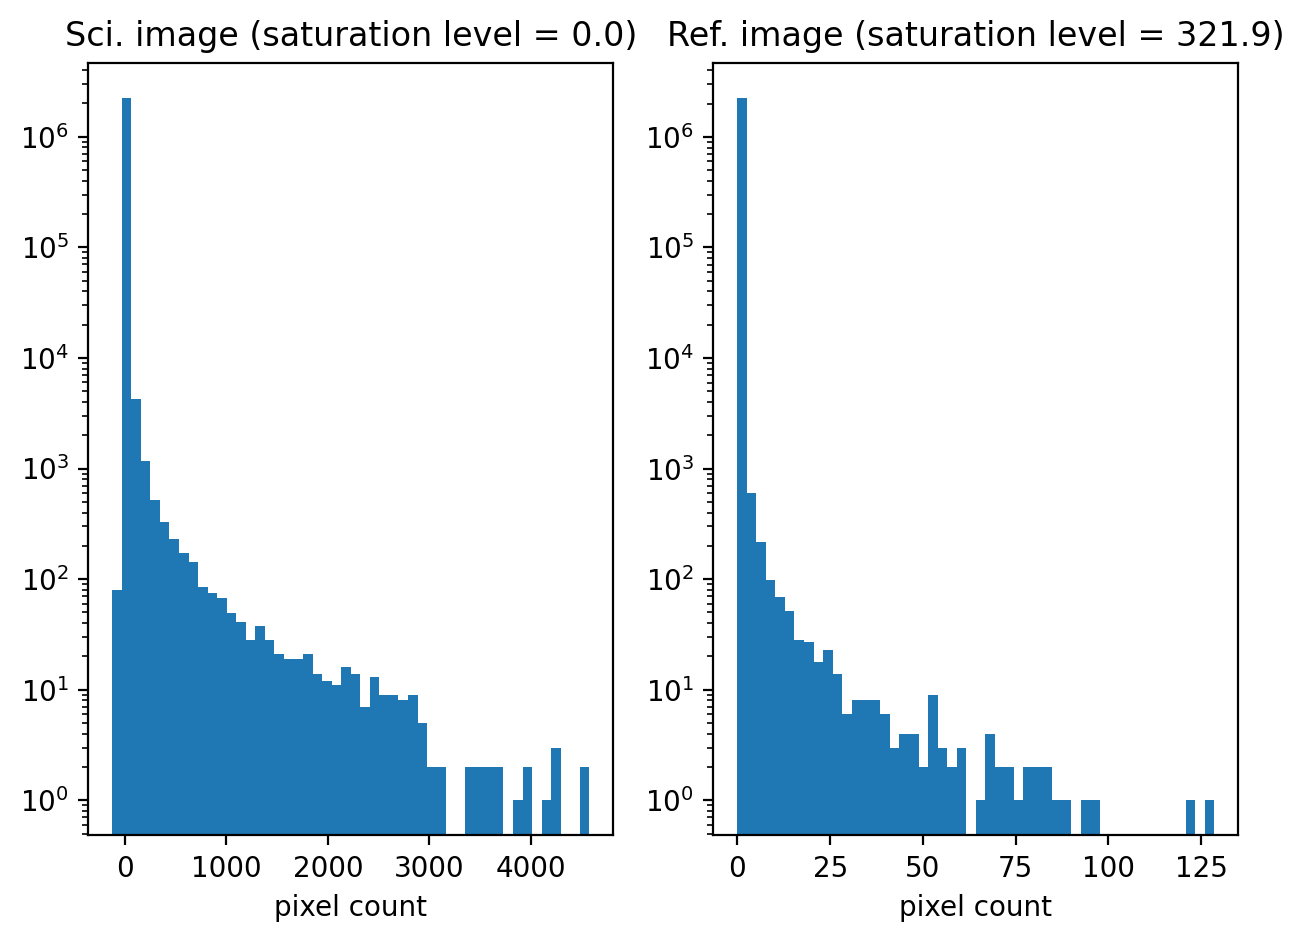

In [7]:
# Pixel count histogram
data1d_sci = data_sci_peak_bkgsub.flatten()
data1d_ref = data_ref_peak_bkgsub.flatten()
# Get saturation count
try:
    saturate_sci = header_sci_peak['SATURATE']
except:
    saturate_sci = 0
try:
    saturate_ref = header_ref_peak['SATURATE']
except:
    saturate_ref = 0
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol)
axes[0].hist(data1d_sci, bins=50, log=True)
axes[0].set_xlabel('pixel count')
axes[0].set_title('Sci. image (saturation level = {:.1f})'.format(saturate_sci))
axes[1].hist(data1d_ref, bins=50, log=True)
axes[1].set_title('Ref. image (saturation level = {:.1f})'.format(saturate_ref))
axes[1].set_xlabel('pixel count')
plt.tight_layout()

In [8]:
fits_diff = runhotpants(sci_img=fits_sci_peak, ref_img=fits_ref_peak, frame_num=11, out_dir=out_dir)

# of frames = 11


# of frames = 11


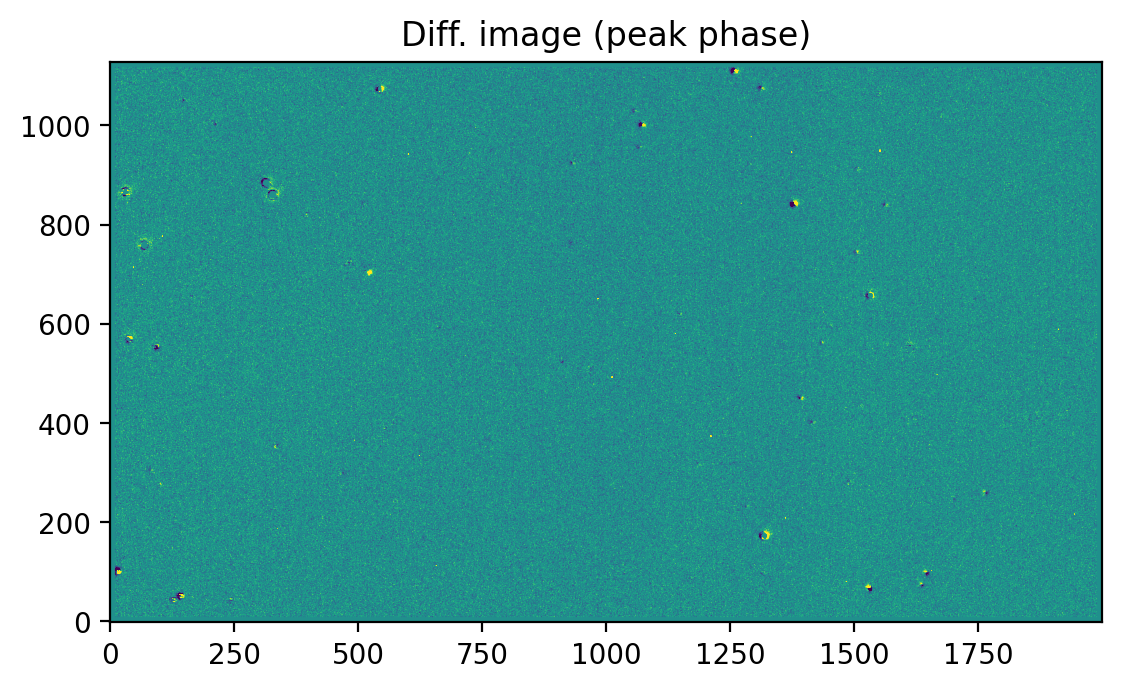

In [9]:
fits_diff = runhotpants(sci_img=fits_sci_peak, ref_img=fits_ref_peak, frame_num=11, out_dir=out_dir)

header_diff, data_diff = tomoeutils.openfits(fits_diff)
mean_diff = np.mean(data_diff)
std_diff = np.std(data_diff)
plt.title('Diff. image ({} phase)'.format(sn_phase))
plt.imshow(data_diff, vmin=mean_diff-3*std_diff, vmax=mean_diff+3*std_diff, origin='lower')

In [10]:
# Make PSF model
data_psf, header_psf, df_psfstars = mkpsf_func.make_psfmodel(fits_sci_peak, save_dir=out_dir, star_num=25, psfrad=7, fitrad=6)

### 105 PSF stars were found ###
### 25 PSF stars were used ###
STAR  X  Y  MAG  SKY
1 68.17169127350428 758.8679829619008 [12.30229816] 0.039630259509130475

STAR  X  Y  MAG  SKY
2 313.92902024545106 884.0319663774918 [12.30945951] 0.4641973900554839

STAR  X  Y  MAG  SKY
3 30.382566655150605 866.0096330343471 [12.39061449] -0.19969088031305732

STAR  X  Y  MAG  SKY
4 1319.019350261012 173.29014553407922 [12.39533461] -0.6158932063312642

STAR  X  Y  MAG  SKY
5 1611.7186819569117 549.2674433817328 [12.45692805] -0.3846965260624691

STAR  X  Y  MAG  SKY
6 1532.260445739178 657.6068261631042 [12.88493046] -0.43883641678842333

STAR  X  Y  MAG  SKY
7 543.3729547571062 1073.5615589899664 [13.07897738] -0.29520975443238995

STAR  X  Y  MAG  SKY
8 37.98146593323788 569.6428059678269 [13.19438438] 0.4054258623618887

STAR  X  Y  MAG  SKY
9 15.858956459895648 102.39973723556864 [13.52045326] -0.2839749304562773

STAR  X  Y  MAG  SKY
10 1379.6568312299164 841.768140953264 [13.55521308] 0.15512

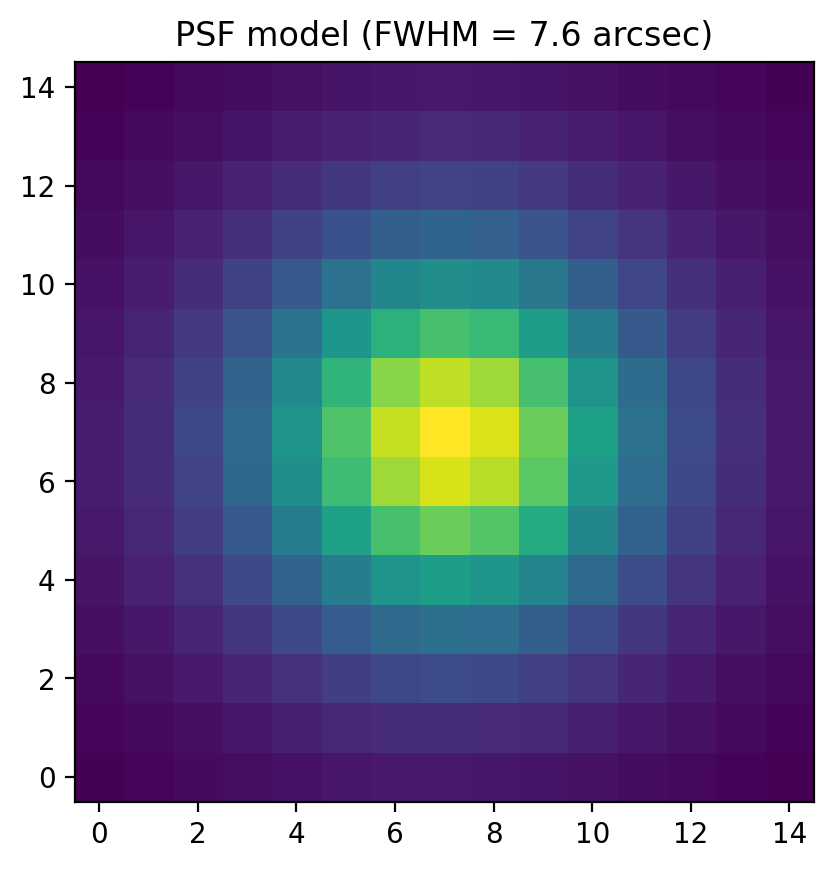

In [11]:
# Check PSF model image
sigma_x = header_psf['GAUSS4']
sigma_y = header_psf['GAUSS5']
fwhm_x = 2.0 * sigma_x * np.sqrt(2.0 * np.log(2)) * 1.19 
fwhm_y = 2.0 * sigma_y * np.sqrt(2.0 * np.log(2)) * 1.19
fwhm = (fwhm_x+fwhm_y)/2.0

mean_psf = np.mean(data_psf)
std_psf = np.std(data_psf)
plt.title('PSF model (FWHM = {:.1f} arcsec)'.format(fwhm))
plt.imshow(data_psf, origin='lower')
#plt.imshow(data_psf, vmin=mean_psf-3*std_psf, vmax=mean_psf+3*std_psf, origin='lower')

In [12]:
# data_psf_rev = np.flip(data_psf.copy())
# psf_conv = signal.convolve2d(data_psf, data_psf_rev, mode='same')
# print(psf_conv)
# plt.imshow(psf_conv, origin='lower')

In [13]:
# Run SEP on the difference image
thresh=2; minarea=1
df_obj, data_bkgsub, data_segmap, bkg_mean, bkg_rms = tomoeutils.detectobj(data_diff, thresh=thresh, minarea=minarea, filter_kernel=data_psf, use_segmap=True, radius1=5.0, radius2=7.0, gain=0.23)

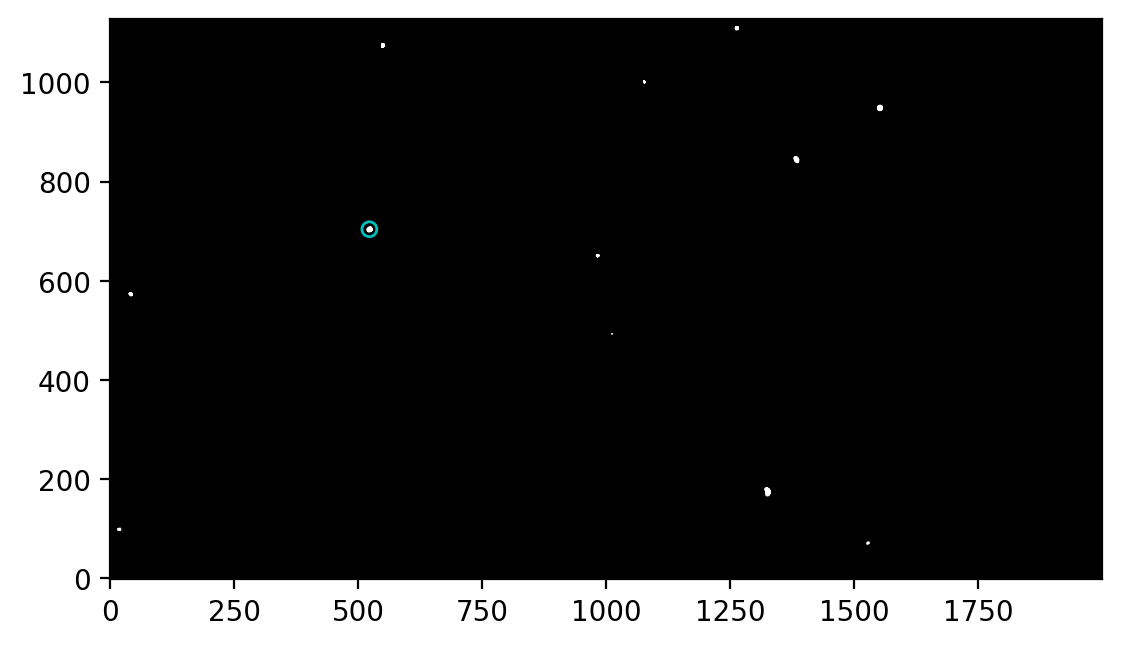

In [14]:
ax = plt.axes()
c = patches.Circle(xy=(x_peak_pix, y_peak_pix), radius=15, fill=False, ec='c', lw=1, label='{}'.format(sn_name))
ax.add_patch(c)
plt.imshow(data_segmap, origin='lower', vmin=0, vmax=1, cmap='gray')

In [15]:
df_obj

thresh  npix  tnpix  xmin  xmax  ymin  ymax            x            y  \
0   0.085813    41     31  1524  1531    69    75  1527.769288    71.870324   
1   0.085813    39     38    15    22    97   102    18.133093    99.502840   
2   0.085813   158     94  1320  1331   167   183  1325.519458   175.167850   
3   0.085813     3      1  1011  1012   493   494  1011.664668   493.319351   
4   0.085813    44     26    38    45   570   576    41.600190   573.203476   
5   0.085813    31      5   980   986   648   653   982.790583   650.848974   
6   0.085813    92     78   518   528   699   709   523.082552   703.713898   
7   0.085813    95     71  1379  1388   838   850  1383.430892   844.311061   
8   0.085813   104      5  1547  1557   943   954  1551.949242   948.277300   
9   0.085813    17     15  1075  1079   999  1003  1076.819501  1000.818861   
10  0.085813    46     33   547   552  1070  1078   549.416848  1074.279676   
11  0.085813    40     37  1260  1266  1106  1112  1263.313883  1108.961832   

          x2         y2        xy     errx2     erry2         errxy         a  \
0   3.425802   2.769534  0.718766  0.013890  0.011515  3.024929e-03  1.971748   
1   3.494831   2.287593  0.340250  0.012113  0.007826  1.154660e-03  1.893178   
2   7.235762  17.411282 -2.025857  0.005078  0.011677 -1.395756e-03  4.218978   
3   0.222885   0.217366  0.107089  0.016870  0.016884  8.436831e-03  0.572057   
4   3.735357   2.860628 -0.729889  0.013527  0.010282 -2.662939e-03  2.036882   
5   2.411164   1.998949  0.034948  0.011567  0.009328  2.256757e-04  1.553739   
6   6.847974   6.087060  0.913571  0.009609  0.008501  1.308642e-03  2.730777   
7   5.338608   7.998097 -1.909178  0.004986  0.007574 -1.880054e-03  2.999163   
8   5.837494   5.927663 -0.008548  0.002991  0.003086  2.082122e-07  2.434844   
9   1.155802   1.499006 -0.024110  0.014305  0.018498 -3.697366e-04  1.225027   
10  2.464293   4.681370  0.195738  0.008858  0.017101  7.678932e-04  2.167607   
11  2.640301   3.225139  0.155565  0.010160  0.012425  6.173274e-04  1.806639   

           b     theta       cxx       cyy       cxy      cflux       flux  \
0   1.519060  0.571265  0.308712  0.381865 -0.160238   4.481978   9.487927   
1   1.482667  0.256644  0.290341  0.443564 -0.086369   4.795339  12.689843   
2   2.616728 -1.381327  0.142856  0.059368  0.033244  22.366154  28.946091   
3   0.336156  0.772518  5.878012  6.027244 -5.791792   0.269729   5.333623   
4   1.564320 -0.515475  0.281760  0.367917  0.143782   4.955560  10.183735   
5   1.412801  0.083982  0.414843  0.500390 -0.014505   3.687390   9.111197   
6   2.340489  0.588095  0.149012  0.167639 -0.044729  11.772093  17.175217   
7   2.083681 -1.089585  0.204797  0.136699  0.097772  15.075497  27.377365   
8   2.415924 -1.477112  0.171307  0.168701  0.000494  22.824230  28.320066   
9   1.074298 -1.501005  0.865491  0.667333  0.027841   1.623093   3.852348   
10  1.564335  1.483411  0.407148  0.214324 -0.034047   5.021233   9.221539   
11  1.612915  1.326340  0.379824  0.310948 -0.036642   4.567891   9.559202   

       cpeak       peak  xcpeak  ycpeak  xpeak  ypeak  flag  ap1flux_5pix  \
0   0.138878   0.757749    1528      71   1530     70     0     13.519976   
1   0.159050   0.844671      18     100     18    101     0     16.683754   
2   0.219910   0.880645    1326     174   1325    172     0     17.885070   
3   0.093142   5.289016    1012     493   1012    493     0      4.998105   
4   0.144623   0.682878      42     573     42    573     0     11.230583   
5   0.165591   8.792415     983     651    983    651     0      9.437213   
6   0.184649   0.422684     523     704    523    705     0     15.949166   
7   0.262929   1.114656    1383     844   1382    842     0     26.195297   
8   0.512559  27.519203    1552     948   1552    948     0     28.351142   
9   0.106191   0.455586    1077    1001   1076   1002     0      9.618241   
10  0.135411   0.697710     549    1074    548   1074     0   

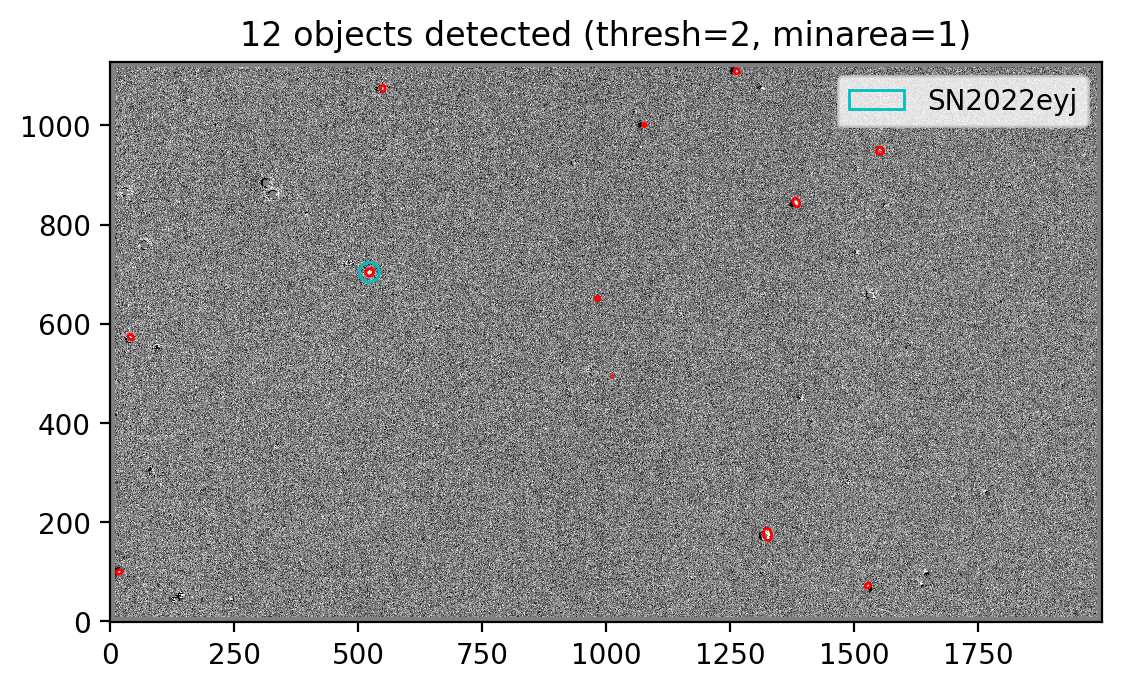

In [16]:
# Show detected objects on the difference image

fig, ax = plt.subplots()
ax.set_title('{0} objects detected (thresh={1}, minarea={2})'.format(len(df_obj), thresh, minarea))
im = ax.imshow(data_diff, interpolation='nearest', cmap='gray', \
               vmin=mean_diff-3*std_diff, vmax=mean_diff+3*std_diff, origin='lower')
# plot an ellipse for each object
for i in range(len(df_obj)):
    e = Ellipse(xy=(df_obj['x'][i], df_obj['y'][i]),
                width=6*df_obj['a'][i],
                height=6*df_obj['b'][i],
                angle=df_obj['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
c = patches.Circle(xy=(x_peak_pix, y_peak_pix), radius=20, fill=False, ec='c', lw=1, label='{}'.format(sn_name))
ax.add_artist(c)
ax.legend()

## At pre-maximum

In [17]:
# Position of SN2022eyj
ra, dec = 169.502292, +7.845739 # in degree (from TNS)
w_rise = WCS(header_sci_rise)
sn_pos = SkyCoord(ra, dec, frame='icrs', unit='deg')
x_rise_pix, y_rise_pix = w_rise.world_to_pixel(sn_pos) # in pixel
print(x_rise_pix, y_rise_pix)

509.5490370269431 748.5313897367226


Set OBSGEO-Y to  3491287.525 from OBSGEO-[LBH].
Set OBSGEO-Z to  3710653.939 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


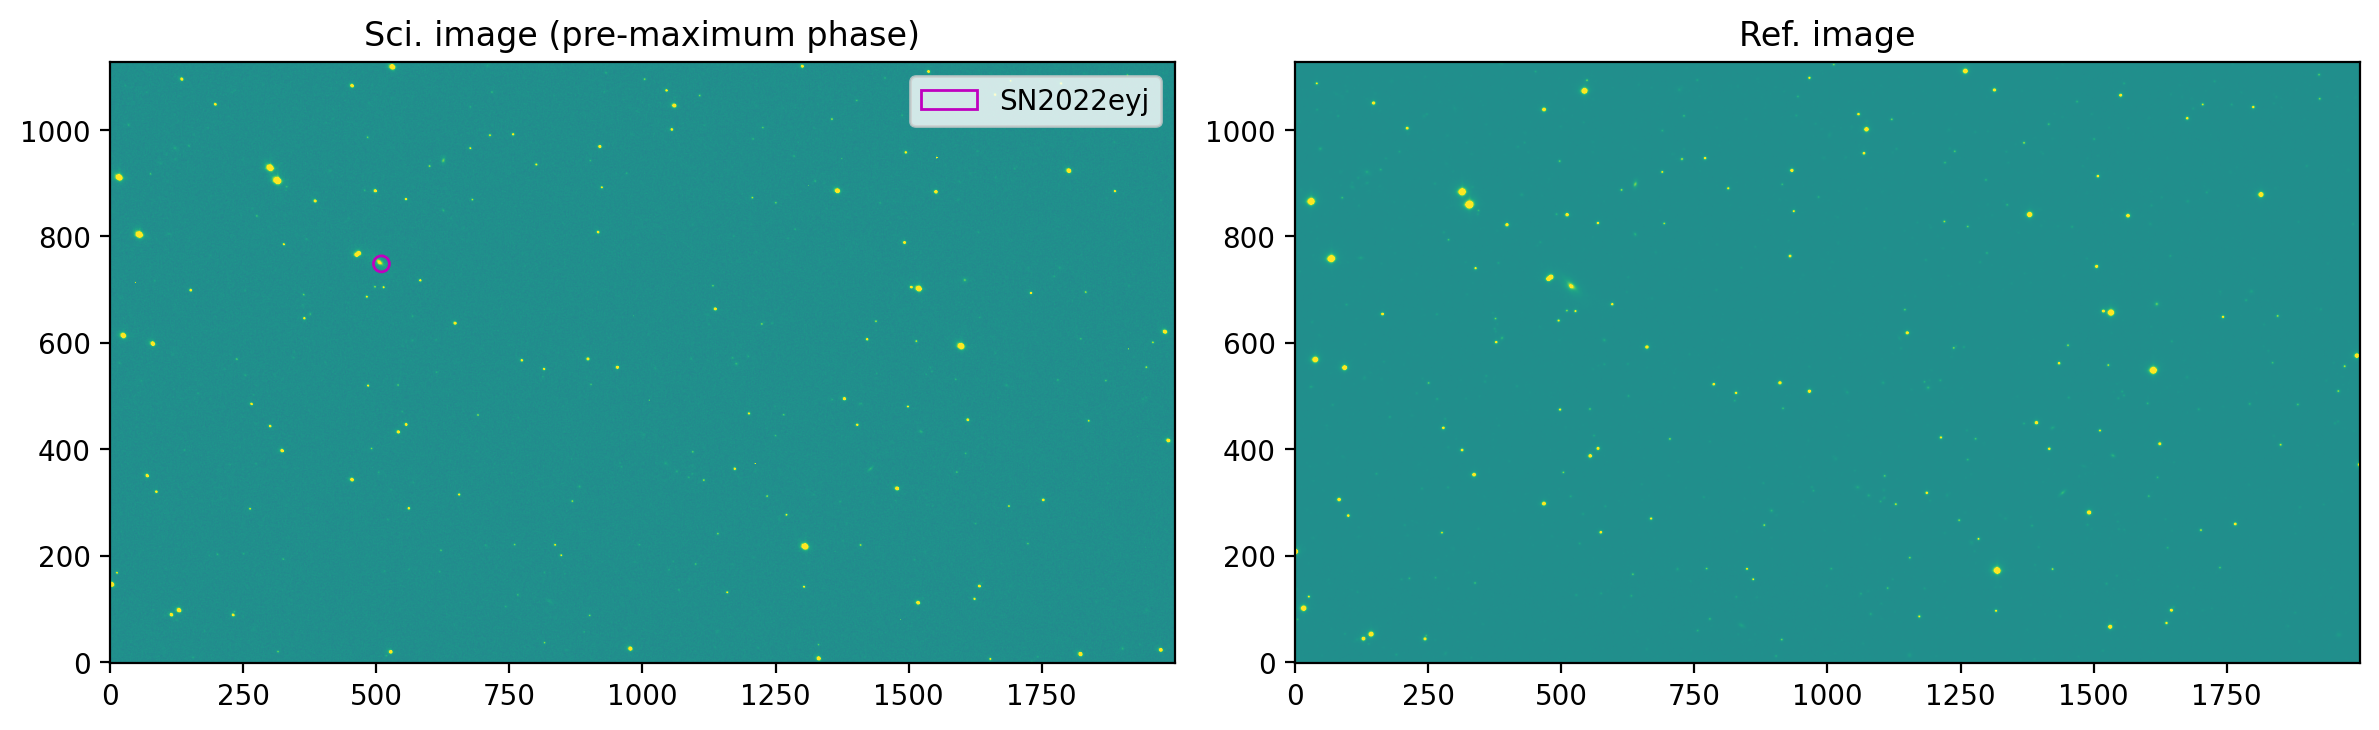

In [18]:
# Show image
sn_name = 'SN2022eyj'
sn_phase = 'pre-maximum'
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol, figsize=(12,8))
axes[0].imshow(data_sci_rise_bkgsub, vmin=mean_sci_rise-3*std_sci_rise, vmax=mean_sci_rise+3*std_sci_rise, origin='lower')
axes[0].set_title('Sci. image ({} phase)'.format(sn_phase))
c = patches.Circle(xy=(x_rise_pix, y_rise_pix), radius=15, fill=False, ec='m', lw=1, label='{}'.format(sn_name))
axes[0].add_patch(c)
axes[1].imshow(data_ref_peak_bkgsub, vmin=mean_ref_peak-3*std_ref_peak, vmax=mean_ref_peak+3*std_ref_peak, origin='lower')
axes[1].set_title('Ref. image')
axes[0].legend()
plt.tight_layout()

In [19]:
wcs_rise = WCS(header_sci_rise)
wcs_rise

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 169.823899698  7.9423300983  
CRPIX : 1476.24813843  461.423912048  
CD1_1 CD1_2  : 0.000330387398426  1.47673841274e-06  
CD2_1 CD2_2  : 1.28828726638e-06  -0.000330326454776  
NAXIS : 2000  1128

In [20]:
fits_diff_rise = runhotpants(sci_img=fits_sci_rise, ref_img=fits_ref_rise, frame_num=11, out_dir=out_dir)

# of frames = 11


# of frames = 11


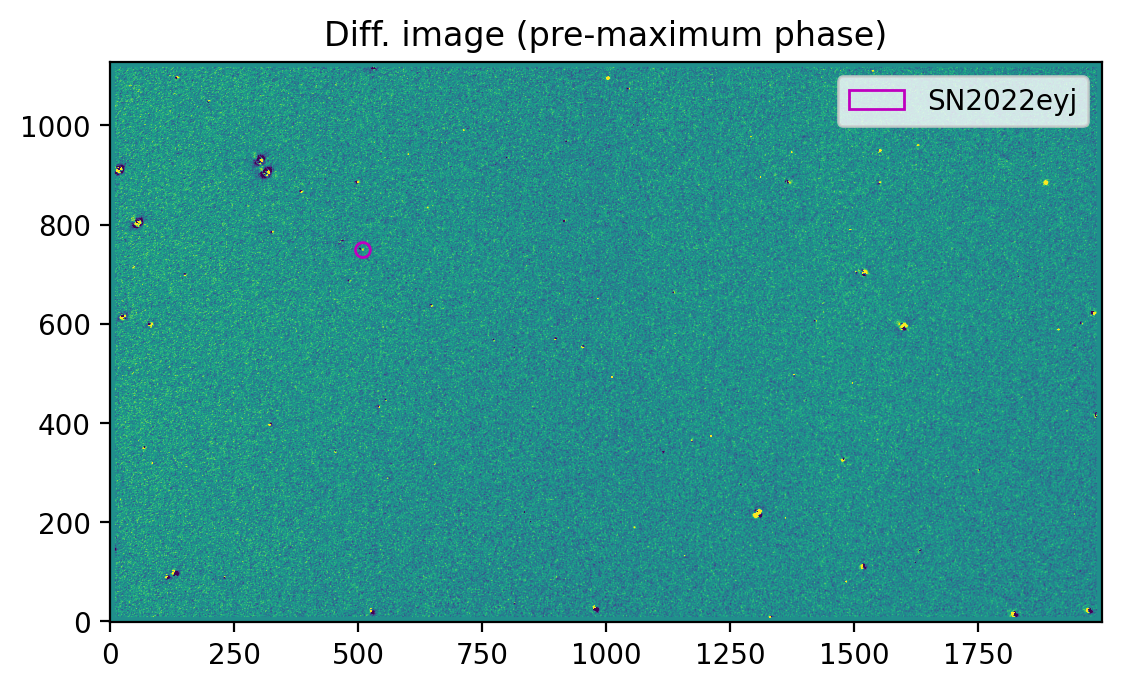

In [21]:
fits_diff_rise = runhotpants(sci_img=fits_sci_rise, ref_img=fits_ref_rise, frame_num=11, out_dir=out_dir)
fig, ax = plt.subplots()
header_diff_rise, data_diff_rise = tomoeutils.openfits(fits_diff_rise)
mean_diff_rise = np.mean(data_diff_rise)
std_diff_rise = np.std(data_diff_rise)
ax.set_title('Diff. image ({} phase)'.format(sn_phase))
c = patches.Circle(xy=(x_rise_pix, y_rise_pix), radius=15, fill=False, ec='m', lw=1, label='{}'.format(sn_name))
ax.add_patch(c)
ax.legend()
ax.imshow(data_diff_rise, vmin=mean_diff_rise-3*std_diff_rise, vmax=mean_diff_rise+3*std_diff_rise, origin='lower')